****Imports & Initialization****

In [199]:
import pickle
from pathlib import Path
import warnings
from collections import defaultdict

import pandas as pd
import networkx as nx   
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning
from dowhy import CausalModel
from estimation_utils import matching_ate  # <- our custom matching ATE estimator
from structure_data import choose_columns, preprocess_data
# set random seed
import numpy as np
import random
np.random.seed(9)
random.seed(9)
import matplotlib.pyplot as plt
BLUE = '#1f77b4'
ORANGE = '#ff7f0e'
GREEN = '#2ca02c'
RED = '#d62728'
PURPLE = '#9467bd'
BROWN = '#8c564b'
PINK = '#e377c2'
GRAY = '#7f7f7f'

In [200]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [201]:
ROOT = Path("./")
RAW_DATA = ROOT / "raw_data/csv/eqls_2007and2011.csv"
DICT_PATH = ROOT / "data/dictionary.json"
GRAPH_PATH = ROOT / "graphs/full_causal.gpickle"
TREATMENT = "Y11_Q57"
OUTCOME = "Y11_MWIndex"


def _prep_ordinals_inplace(df: pd.DataFrame, ord_cols, known_orders=None):
    """
    Map ordinal levels to 0..m-1 and scale to [0,1] so L1 equals Gower per-feature.
    known_orders: optional dict {col: [lowest,...,highest]} to control ordering.
    """
    for c in ord_cols:
        if known_orders and c in known_orders:
            order = {v: i for i, v in enumerate(known_orders[c])}
            df[c] = df[c].map(order).astype(float)
            m = max(order.values()) if order else 1
            df[c] = df[c] / (m if m > 0 else 1.0)
        else:
            # infer: if numeric-coded, scale min–max; else sort unique labels
            if pd.api.types.is_numeric_dtype(df[c]):
                lo, hi = df[c].min(), df[c].max()
                rng = (hi - lo) if hi > lo else 1.0
                df[c] = (df[c] - lo) / rng
            else:
                levels = sorted(df[c].dropna().unique().tolist())
                mapping = {v: i for i, v in enumerate(levels)}
                m = max(mapping.values()) if mapping else 1
                df[c] = df[c].map(mapping).astype(float) / (m if m > 0 else 1.0)

def _apply_ordinals_binning(df: pd.DataFrame, ord_cols, n_bins=4):
    for c in ord_cols:
        df[c] = pd.qcut(df[c], q=n_bins, labels=False, duplicates="drop")

def load_data() -> pd.DataFrame:
    """Load and preprocess the raw EQLS data."""
    bdvs = [
        "Y11_EmploymentStatus",
        "Y11_HHstructure",
        "Y11_HHsize",
        "Y11_Agecategory",
        "Y11_Q7",
        "Y11_Q31",
        "Y11_Country",
        "Y11_Q32",
        "Y11_HH2a",
        TREATMENT,
        OUTCOME,
    ]
    df = choose_columns()
    df = preprocess_data(
        df,
        na_threshold=0.5,
        impute_strategy="drop",
        treatment_dichotomize_value="median",
        treatment_column=TREATMENT,
        backdoor_variables=bdvs,
    )
    df.to_csv("data/eqls_processed.csv", index=False)
    return df


def get_schema() -> dict:
    categorical = ["Y11_Q32", "Y11_Q7"]
    ordinal = [
        "Y11_Agecategory",
        "Y11_Country",
        "Y11_EmploymentStatus",
        "Y11_HH2a",
        "Y11_HHsize",
        "Y11_HHstructure",
        "Y11_Q31",
    ]
    return {"cat": categorical, "ord": ordinal}


def load_graph() -> nx.DiGraph:
    """Load the causal graph describing relationships among variables."""
    with open(GRAPH_PATH, "rb") as f:
        return pickle.load(f)


def t_learner_estimate(
    df: pd.DataFrame,
    schema: dict,
    treatment_col: str,
    outcome_col: str,
) -> float:
    """
    T-learner ATE using two outcome models:
      - f1 trained on treated data
      - f0 trained on control data
    Returns mean_i [ f1(x_i) - f0(x_i) ].
    If outcome is not binary {0,1}, falls back to linear regression.

    Assumes df already has ordinal columns numerically scaled.
    """
    # Features: confounders only (no T, no Y)
    feat_cols = schema["cat"] + schema["ord"]
    X = df[feat_cols].copy()

    # Ensure categoricals are treated as such, then one-hot on FULL X (to align cols)
    for c in schema["cat"]:
        X[c] = X[c].astype("category")
    X_enc = pd.get_dummies(X, columns=schema["cat"], drop_first=True)

    T = df[treatment_col].astype(int).values
    y = df[outcome_col].values

    X1, y1 = X_enc[T == 1], y[T == 1]
    X0, y0 = X_enc[T == 0], y[T == 0]

    g1 = LinearRegression()
    g0 = LinearRegression()
    g1.fit(X1, y1)
    g0.fit(X0, y0)
    mu1 = g1.predict(X_enc)
    mu0 = g0.predict(X_enc)

    ite = mu1 - mu0
    ate = float(np.nanmean(ite))
    return ate

def load_model(df, graph, kwargs={}) -> CausalModel: 
    df2 = df.copy()
    _prep_ordinals_inplace(df2, get_schema()["ord"])
    if "ordinals_binning" in kwargs and "n" in kwargs:
        print("applying ordinals binning")
        _apply_ordinals_binning(df2, get_schema()["ord"])

    return CausalModel(
        data=df2,
        treatment=TREATMENT,
        outcome=OUTCOME,
        graph=nx.nx_pydot.to_pydot(graph).to_string(),
    )

Estimate effects & Default configuration

In [202]:
METHODS = [
        "backdoor.propensity_score_matching",
        "backdoor.propensity_score_weighting",
        "backdoor.propensity_score_stratification",
        "backdoor.linear_regression",
        "backdoor.exact_matching_manual",
        "backdoor.T_learner",  # <- custom
    ]
DEFAULT_KWARGS = {
        "backdoor.exact_matching_manual": dict(
                ord_cols= get_schema()["ord"],
                cat_cols= get_schema()["cat"],
                ord_mode= "continuous",
                distance_metric= "minkowski",
                p= 1,
                num_matches_per_unit= 1,
        )
    }


def estimate_effects(df: pd.DataFrame, graph: nx.DiGraph, model: CausalModel, methods: list = METHODS, kwargs: dict = DEFAULT_KWARGS) -> dict:

    estimand = model.identify_effect()
    results = {}
    for m in methods:
        print(f"Estimating with method: {m}")
        try:
            if m == "backdoor.T_learner":
                # Call our custom estimator
                ate = t_learner_estimate(
                    df, get_schema(), treatment_col=TREATMENT, outcome_col=OUTCOME
                )
                results[m] = ate
            elif m == "backdoor.exact_matching_manual":
                ate = matching_ate(
                    df,
                    treat_col=TREATMENT,
                    outcome_col=OUTCOME,
                    **kwargs.get(m, {})
                )
                results[m] = ate
            else:
                est = model.estimate_effect(
                    estimand, method_name=m, **kwargs.get(m, {})
                )
                results[m] = float(est.value)
        except Exception as e:
            print(f"[!] Estimation with {m} failed: {e}")
            results[m] = float("nan")
    return results

In [203]:
df = load_data()
graph = load_graph()

In [204]:
backdoor_variables = ['Y11_EmploymentStatus',
 'Y11_HHstructure',
 'Y11_HHsize',
 'Y11_Agecategory',
 'Y11_Q7',
 'Y11_Q31',
 'Y11_Country',
 'Y11_Q32',
 'Y11_HH2a',
]
treatment_and_outcome = [TREATMENT, OUTCOME]

****Robustness Checks****

Matching

In [205]:
# Sweep values
distance_metrics = ["minkowski", "mahalanobis"]
p_values = [1, 2]
num_matches_values = [1, 2, 3]
ord_modes = ["exact", "continuous"]
binning_values = [None, 3, 4, 5]
ates = []
matched_fractions = []

for ord_mode in ord_modes:        
    if ord_mode == "exact":
        # Run once per binning (distance irrelevant here)
        for binning in binning_values:
            try:
                ate, details = matching_ate(
                    df,
                    cat_cols=get_schema()["cat"],
                    ord_cols=get_schema()["ord"],
                    treat_col=TREATMENT,
                    outcome_col=OUTCOME,
                    ord_mode="exact",
                    ord_binning=binning,
                    return_details=True
                )
                print(
                    f"ord_mode=exact, binning={binning}, => ATE={ate:.4f}, matched_fraction={details['matched_fraction']:.3f}"
                )
                ates.append(ate)
                matched_fractions.append(details['matched_fraction'])
            except Exception as e:
                print(
                    f"ord_mode=exact, binning={binning}=> {str(e)}"
                )

    else:  # ord_mode == "continuous"
        for metric in distance_metrics:
            # decide which p values to test
            if metric == "minkowski":
                ps = p_values
            else:
                ps = [None]  # p not relevant

            for p in ps:
                for k in num_matches_values:
                    try:
                        # omit the original config
                        if p==1 and metric=="minkowski" and k==1:
                            continue
                        ate, details = matching_ate(
                            df,
                            cat_cols=get_schema()["cat"],
                            ord_cols=get_schema()["ord"],
                            treat_col=TREATMENT,
                            outcome_col=OUTCOME,
                            ord_mode="continuous",
                            ord_binning=None,  # ignore binning
                            distance_metric=metric,
                            p=p if p is not None else 2,
                            num_matches_per_unit=k,
                            return_details=True
                        )
                        print(
                            f"ord_mode=continuous, metric={metric}, p={p}, k={k} => ATE={ate:.4f}, matched_fraction={details['matched_fraction']:.3f}"
                        )
                        ates.append(ate)
                        matched_fractions.append(details['matched_fraction'])
                    except Exception as e:
                        print(
                            f"ord_mode=continuous, metric={metric}, p={p}, k={k} => {str(e)}"
                        )

ord_mode=exact, binning=None, => ATE=5.6774, matched_fraction=0.463
ord_mode=exact, binning=3, => ATE=6.8284, matched_fraction=0.878
ord_mode=exact, binning=4, => ATE=6.9018, matched_fraction=0.893
ord_mode=exact, binning=5, => ATE=7.0185, matched_fraction=0.826
ord_mode=continuous, metric=minkowski, p=1, k=2 => ATE=6.2911, matched_fraction=0.998
ord_mode=continuous, metric=minkowski, p=1, k=3 => ATE=6.2899, matched_fraction=0.998
ord_mode=continuous, metric=minkowski, p=2, k=1 => ATE=6.3366, matched_fraction=0.998
ord_mode=continuous, metric=minkowski, p=2, k=2 => ATE=6.5154, matched_fraction=0.998
ord_mode=continuous, metric=minkowski, p=2, k=3 => ATE=6.4295, matched_fraction=0.998
ord_mode=continuous, metric=mahalanobis, p=None, k=1 => ATE=6.5561, matched_fraction=0.998
ord_mode=continuous, metric=mahalanobis, p=None, k=2 => ATE=6.3377, matched_fraction=0.998
ord_mode=continuous, metric=mahalanobis, p=None, k=3 => ATE=6.3426, matched_fraction=0.998


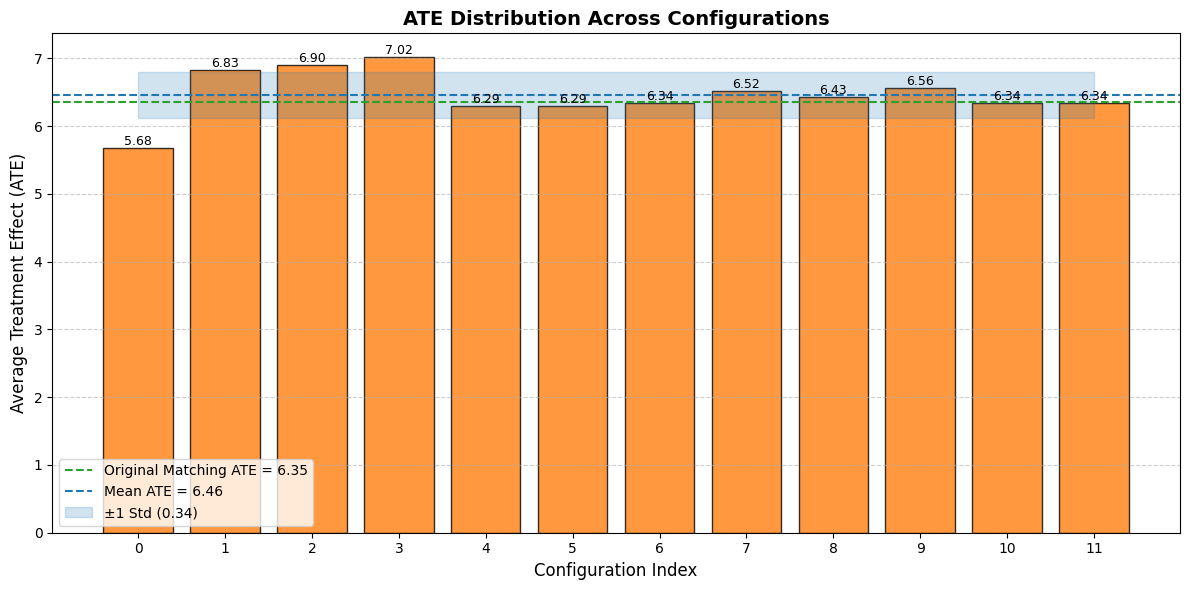

In [206]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

# Bar plot
bars = plt.bar(range(len(ates)), ates, color=ORANGE, edgecolor='black', alpha=0.8)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{ates[i]:.2f}",
        ha='center', va='bottom', fontsize=9
    )

# Reference lines
matching_original_ate = 6.35 # Taken from the original matching results
plt.axhline(
    y=matching_original_ate, color=GREEN, linestyle='--',
    label=f'Original Matching ATE = {matching_original_ate:.2f}'
)
plt.axhline(
    y=np.mean(ates), color=BLUE, linestyle='--',
    label=f'Mean ATE = {np.mean(ates):.2f}'
)
plt.fill_between(
    range(len(ates)),
    np.mean(ates) - np.std(ates),
    np.mean(ates) + np.std(ates),
    color=BLUE, alpha=0.2, label=f"±1 Std ({np.std(ates):.2f})"
)

# Style improvements
plt.title("ATE Distribution Across Configurations", fontsize=14, fontweight='bold')
plt.xlabel("Configuration Index", fontsize=12)
plt.ylabel("Average Treatment Effect (ATE)", fontsize=12)
plt.xticks(range(len(ates)))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

Subset Analysis- per country assesment

In [207]:
dfs_per_countries = defaultdict(list)
results_per_country = defaultdict(dict)
for country in df['Y11_Country'].unique():
    dfs_per_countries[country] = df[df['Y11_Country'] == country]
for country, df_country in dfs_per_countries.items():
    model = load_model(df_country, graph)
    results_per_country[int(country)] = estimate_effects(df_country, graph, model)
    print(f"Results for country {country}: {results_per_country[int(country)]}")

# save to json
import json
with open("results_per_country.json", "w") as f:
    json.dump(results_per_country, f)


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 15: {'backdoor.propensity_score_matching': 7.312759097190235, 'backdoor.propensity_score_weighting': 5.585618773865285, 'backdoor.propensity_score_stratification': 5.368133769716942, 'backdoor.linear_regression': 5.362736044608205, 'backdoor.exact_matching_manual': 4.585603112840467, 'backdoor.T_learner': 5.71987064370324}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 6: {'backdoor.propensity_score_matching': 6.107155202212237, 'backdoor.propensity_score_weighting': 5.100152090215758, 'backdoor.propensity_score_stratification': 4.662959117691009, 'backdoor.linear_regression': 4.832114862532805, 'backdoor.exact_matching_manual': 6.447954055994257, 'backdoor.T_learner': 4.794948045729591}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 12: {'backdoor.propensity_score_matching': 2.1531531531531534, 'backdoor.propensity_score_weighting': 2.578653511443825, 'backdoor.propensity_score_stratification': 0.9102468826874246, 'backdoor.linear_regression': 2.189808467720127, 'backdoor.exact_matching_manual': 0.5648854961832062, 'backdoor.T_learner': 2.468776576078513}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 27: {'backdoor.propensity_score_matching': 6.220370370370371, 'backdoor.propensity_score_weighting': 7.595363893647253, 'backdoor.propensity_score_stratification': 5.12456516107847, 'backdoor.linear_regression': 6.944385892963936, 'backdoor.exact_matching_manual': 7.008411677387432, 'backdoor.T_learner': 7.454430568075059}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 10: {'backdoor.propensity_score_matching': 3.3204951856946354, 'backdoor.propensity_score_weighting': 4.769517878108765, 'backdoor.propensity_score_stratification': 4.667335864527221, 'backdoor.linear_regression': 4.6039862553475075, 'backdoor.exact_matching_manual': 3.2540861812778603, 'backdoor.T_learner': 4.453409688429945}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 20: {'backdoor.propensity_score_matching': 4.821973550356053, 'backdoor.propensity_score_weighting': 3.983111612938501, 'backdoor.propensity_score_stratification': 3.938767775255412, 'backdoor.linear_regression': 3.801810152844027, 'backdoor.exact_matching_manual': 5.12694877505568, 'backdoor.T_learner': 3.4619346854332074}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 22: {'backdoor.propensity_score_matching': 4.355464759959142, 'backdoor.propensity_score_weighting': 8.361083075467363, 'backdoor.propensity_score_stratification': 8.009452180224201, 'backdoor.linear_regression': 7.418672451260377, 'backdoor.exact_matching_manual': 6.535398230088496, 'backdoor.T_learner': 9.087313892910215}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 2: {'backdoor.propensity_score_matching': 3.627049180327869, 'backdoor.propensity_score_weighting': 4.206010955572189, 'backdoor.propensity_score_stratification': 2.354127274156553, 'backdoor.linear_regression': 3.7161128509638317, 'backdoor.exact_matching_manual': 2.1454545454545455, 'backdoor.T_learner': 3.8442627926593396}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 1: {'backdoor.propensity_score_matching': 2.850251256281407, 'backdoor.propensity_score_weighting': 3.114765530996962, 'backdoor.propensity_score_stratification': 2.6134699872821407, 'backdoor.linear_regression': 3.0948077290780134, 'backdoor.exact_matching_manual': 3.343963553530752, 'backdoor.T_learner': 3.120864470609957}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 9: {'backdoor.propensity_score_matching': 9.263589743589744, 'backdoor.propensity_score_weighting': 10.044189479132186, 'backdoor.propensity_score_stratification': 8.419635859742186, 'backdoor.linear_regression': 9.754800007233563, 'backdoor.exact_matching_manual': 8.500601684717209, 'backdoor.T_learner': 9.672937633400135}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 24: {'backdoor.propensity_score_matching': 4.529230769230769, 'backdoor.propensity_score_weighting': 4.842403839160028, 'backdoor.propensity_score_stratification': 4.412037335499167, 'backdoor.linear_regression': 4.822845560364286, 'backdoor.exact_matching_manual': 5.674523007856341, 'backdoor.T_learner': 4.846679332323298}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 7: {'backdoor.propensity_score_matching': 2.650698602794411, 'backdoor.propensity_score_weighting': 2.78930661980489, 'backdoor.propensity_score_stratification': 3.8034358651232965, 'backdoor.linear_regression': 2.893936491797845, 'backdoor.exact_matching_manual': 3.9097744360902253, 'backdoor.T_learner': 3.757056032139355}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 11: {'backdoor.propensity_score_matching': 4.133603238866397, 'backdoor.propensity_score_weighting': 3.27393731685774, 'backdoor.propensity_score_stratification': 2.908538131777993, 'backdoor.linear_regression': 3.146186331116226, 'backdoor.exact_matching_manual': 3.4221724524076147, 'backdoor.T_learner': 3.4681698067807427}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 14: {'backdoor.propensity_score_matching': 4.7358121330724074, 'backdoor.propensity_score_weighting': 4.0619638322512515, 'backdoor.propensity_score_stratification': 3.9349087111628256, 'backdoor.linear_regression': 3.677604615647155, 'backdoor.exact_matching_manual': 3.8456449834619626, 'backdoor.T_learner': 4.235117849627044}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 17: {'backdoor.propensity_score_matching': 2.9413020277481325, 'backdoor.propensity_score_weighting': 2.7645186739324714, 'backdoor.propensity_score_stratification': 4.414057212389181, 'backdoor.linear_regression': 2.7761740798394072, 'backdoor.exact_matching_manual': 3.9761620977353993, 'backdoor.T_learner': 3.6599913991420183}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 21: {'backdoor.propensity_score_matching': 9.745454545454546, 'backdoor.propensity_score_weighting': 7.1281827232692265, 'backdoor.propensity_score_stratification': 7.1619381318009925, 'backdoor.linear_regression': 7.360301340178253, 'backdoor.exact_matching_manual': 8.52784746613146, 'backdoor.T_learner': 7.215325723113653}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 23: {'backdoor.propensity_score_matching': 9.980253878702397, 'backdoor.propensity_score_weighting': 11.46934822017522, 'backdoor.propensity_score_stratification': 11.65131062301676, 'backdoor.linear_regression': 10.622714824167097, 'backdoor.exact_matching_manual': 10.405286343612335, 'backdoor.T_learner': 11.104979789922359}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 13: {'backdoor.propensity_score_matching': 9.312169312169312, 'backdoor.propensity_score_weighting': 9.635239693766664, 'backdoor.propensity_score_stratification': 7.624490974083279, 'backdoor.linear_regression': 9.484184560344204, 'backdoor.exact_matching_manual': 10.235849056603774, 'backdoor.T_learner': 10.58339506599436}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 3: {'backdoor.propensity_score_matching': 9.204767063921993, 'backdoor.propensity_score_weighting': 13.703365839750894, 'backdoor.propensity_score_stratification': 6.941529135565446, 'backdoor.linear_regression': 10.109824494423627, 'backdoor.exact_matching_manual': 14.767726161369193, 'backdoor.T_learner': 16.093012609386502}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 5: {'backdoor.propensity_score_matching': 8.067085953878406, 'backdoor.propensity_score_weighting': 6.84011993203795, 'backdoor.propensity_score_stratification': 6.390564796970617, 'backdoor.linear_regression': 6.314118996429585, 'backdoor.exact_matching_manual': 7.677639046538025, 'backdoor.T_learner': 7.35907082961003}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 26: {'backdoor.propensity_score_matching': 9.163802978235967, 'backdoor.propensity_score_weighting': 8.491212228128695, 'backdoor.propensity_score_stratification': 6.989304996169932, 'backdoor.linear_regression': 7.2646559299004, 'backdoor.exact_matching_manual': 10.46111111111111, 'backdoor.T_learner': 7.038645586208311}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 16: {'backdoor.propensity_score_matching': 6.2304147465437785, 'backdoor.propensity_score_weighting': 6.558001384629691, 'backdoor.propensity_score_stratification': 6.8153192297151275, 'backdoor.linear_regression': 6.092226621674939, 'backdoor.exact_matching_manual': 5.240431795878312, 'backdoor.T_learner': 6.947439941485653}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 18: {'backdoor.propensity_score_matching': 5.217577706323687, 'backdoor.propensity_score_weighting': 5.571716823727577, 'backdoor.propensity_score_stratification': 4.837962209538015, 'backdoor.linear_regression': 4.661991202934502, 'backdoor.exact_matching_manual': 7.62200956937799, 'backdoor.T_learner': 5.192407105290879}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 25: {'backdoor.propensity_score_matching': 6.082304526748971, 'backdoor.propensity_score_weighting': 6.670251775925472, 'backdoor.propensity_score_stratification': 7.0744498205496305, 'backdoor.linear_regression': 6.591932896625423, 'backdoor.exact_matching_manual': 4.447427293064877, 'backdoor.T_learner': 6.247476060256025}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 8: {'backdoor.propensity_score_matching': 8.034632034632034, 'backdoor.propensity_score_weighting': 8.363458879579703, 'backdoor.propensity_score_stratification': 7.1349178813744585, 'backdoor.linear_regression': 7.060828100280979, 'backdoor.exact_matching_manual': 7.518867924528302, 'backdoor.T_learner': 8.304500917441933}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 4: {'backdoor.propensity_score_matching': 9.121608040201005, 'backdoor.propensity_score_weighting': 9.458843518993461, 'backdoor.propensity_score_stratification': 9.258889368957902, 'backdoor.linear_regression': 9.329299332637461, 'backdoor.exact_matching_manual': 9.233809001097695, 'backdoor.T_learner': 8.210473436182884}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 19: {'backdoor.propensity_score_matching': 5.068893528183716, 'backdoor.propensity_score_weighting': 4.270618468235817, 'backdoor.propensity_score_stratification': 5.211475031031862, 'backdoor.linear_regression': 5.120612977233094, 'backdoor.exact_matching_manual': 6.0974477958236655, 'backdoor.T_learner': 4.194396460436721}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 29: {'backdoor.propensity_score_matching': 3.640543364681296, 'backdoor.propensity_score_weighting': 5.934812342980784, 'backdoor.propensity_score_stratification': 5.856032596389489, 'backdoor.linear_regression': 5.824555931644177, 'backdoor.exact_matching_manual': 3.563063063063063, 'backdoor.T_learner': 5.191733945592548}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 34: {'backdoor.propensity_score_matching': 1.9047619047619047, 'backdoor.propensity_score_weighting': 3.461152943566475, 'backdoor.propensity_score_stratification': 2.946486191800346, 'backdoor.linear_regression': 3.3600692240107577, 'backdoor.exact_matching_manual': 3.648038049940547, 'backdoor.T_learner': 3.122896394482376}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 31: {'backdoor.propensity_score_matching': 2.1333333333333333, 'backdoor.propensity_score_weighting': 4.069764365587353, 'backdoor.propensity_score_stratification': 3.273583308305134, 'backdoor.linear_regression': 3.876104443555512, 'backdoor.exact_matching_manual': -1.8423645320197044, 'backdoor.T_learner': 4.040665729029254}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 33: {'backdoor.propensity_score_matching': 5.400644468313641, 'backdoor.propensity_score_weighting': 3.699194946783308, 'backdoor.propensity_score_stratification': 4.712553472406699, 'backdoor.linear_regression': 3.4903042791660255, 'backdoor.exact_matching_manual': 2.2823529411764705, 'backdoor.T_learner': 3.607050245494836}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 30: {'backdoor.propensity_score_matching': 10.378151260504202, 'backdoor.propensity_score_weighting': 9.748935979048738, 'backdoor.propensity_score_stratification': 8.709212042485468, 'backdoor.linear_regression': 8.432094989684273, 'backdoor.exact_matching_manual': 8.125144843568945, 'backdoor.T_learner': 9.604494630512052}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 32: {'backdoor.propensity_score_matching': 9.091290661070305, 'backdoor.propensity_score_weighting': 8.43413000477399, 'backdoor.propensity_score_stratification': 8.163418404073948, 'backdoor.linear_regression': 8.6262981641326, 'backdoor.exact_matching_manual': 10.625, 'backdoor.T_learner': 8.650070332512643}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Estimating with method: backdoor.exact_matching_manual
Estimating with method: backdoor.T_learner
Results for country 28: {'backdoor.propensity_score_matching': 10.542586750788644, 'backdoor.propensity_score_weighting': 11.840149696617857, 'backdoor.propensity_score_stratification': 11.64232741283147, 'backdoor.linear_regression': 11.669452454401451, 'backdoor.exact_matching_manual': 11.317931793179318, 'backdoor.T_learner': 11.558566111423278}


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


****Refutation Tests****

Calculate original ATEs

In [208]:
# First, calculate ATEs for all methods

df = load_data()
graph = load_graph()
methods = [
        "backdoor.propensity_score_matching",
        "backdoor.propensity_score_weighting",
        "backdoor.propensity_score_stratification",
        "backdoor.linear_regression",
    ]

d = df.copy()
_prep_ordinals_inplace(d, get_schema()["ord"])

model = CausalModel(
    data=d,
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph=nx.nx_pydot.to_pydot(graph).to_string(),
)
estimand = model.identify_effect()
ates = {}
for m in METHODS:
    try:
        if m == "backdoor.T_learner":
            #  Skip, not a do-why method
            continue
        elif m == "backdoor.exact_matching_manual":
            # Skip, not a do-why method
            continue
        else:
            print(f"Estimating with method: {m}")
            est = model.estimate_effect(
                estimand, method_name=m, **DEFAULT_KWARGS.get(m, {})
            )
            ates[m] = est
    except Exception as e:
        print(f"[!] Estimation with {m} failed: {e}")
        ates[m] = float("nan")

print("Overall ATEs:")
for method, ate in ates.items():
    print(f"{method}: ATE = {ate.value:.4f}")

Estimating with method: backdoor.propensity_score_matching
Estimating with method: backdoor.propensity_score_weighting
Estimating with method: backdoor.propensity_score_stratification
Estimating with method: backdoor.linear_regression
Overall ATEs:
backdoor.propensity_score_matching: ATE = 6.6014
backdoor.propensity_score_weighting: ATE = 7.1201
backdoor.propensity_score_stratification: ATE = 6.9142
backdoor.linear_regression: ATE = 6.8726


/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [209]:
# Placebo treatment
treatment_refuter = {}
for method in methods:
    if method not in ates:
        continue
    causal_estimate = ates[method]
    res_placebo = model.refute_estimate(estimand, causal_estimate, method_name="placebo_treatment_refuter")
    treatment_refuter[method] = res_placebo
    print(f"Placebo test for {method}: {res_placebo}")



Placebo test for backdoor.propensity_score_matching: Refute: Use a Placebo Treatment
Estimated effect:6.601411446249033
New effect:-0.07239849187935035
p value:0.74

Placebo test for backdoor.propensity_score_weighting: Refute: Use a Placebo Treatment
Estimated effect:7.120085531064994
New effect:-0.8792807894981592
p value:0.0

Placebo test for backdoor.propensity_score_stratification: Refute: Use a Placebo Treatment
Estimated effect:6.9142121844960585
New effect:-0.04027374233873179
p value:0.88



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

Placebo test for backdoor.linear_regression: Refute: Use a Placebo Treatment
Estimated effect:6.872629466263589
New effect:-0.02704525402325231
p value:0.92



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


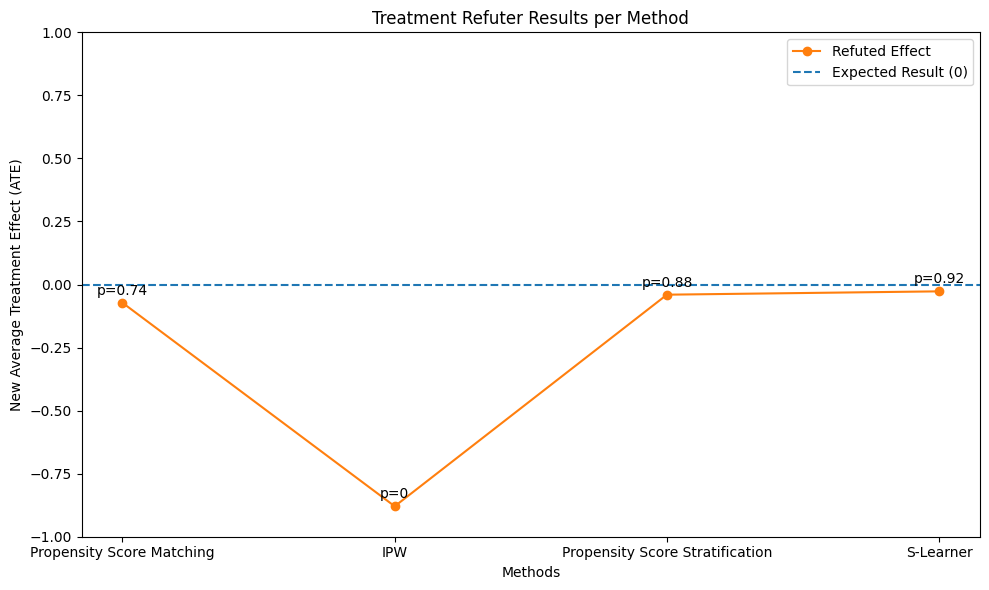

In [210]:
methods_new_names = {
    "backdoor.propensity_score_matching": "Propensity Score Matching",
    "backdoor.propensity_score_weighting": "IPW",
    "backdoor.propensity_score_stratification": "Propensity Score Stratification",
    "backdoor.linear_regression": "S-Learner"
}
methods_names = [methods_new_names[m] for m in treatment_refuter.keys()]
methods = list(treatment_refuter.keys())
results = [treatment_refuter[m].new_effect for m in methods]
p_values = [treatment_refuter[m].refutation_result['p_value'] for m in methods]

plt.figure(figsize=(10, 6))
plt.plot(methods_names, results, marker='o', linestyle='-', color=ORANGE, label='Refuted Effect')
for i, (x, y, p) in enumerate(zip(methods_names, results, p_values)):
    plt.text(i, y + 0.02, f"p={p:.3g}", ha='center', va='bottom', fontsize=10)
plt.xlabel("Methods")
plt.ylabel("New Average Treatment Effect (ATE)")
plt.title("Treatment Refuter Results per Method")
plt.axhline(y=0, color=BLUE, linestyle='--', label='Expected Result (0)')
plt.ylim(-1, 1)
# plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [211]:
# Dummy outcome
outcome_refuter = {}
for method in methods:
    if method not in ates:
        continue
    causal_estimate = ates[method]
    res_dummy_outcome = model.refute_estimate(estimand, causal_estimate, method_name="dummy_outcome_refuter")
    outcome_refuter[method] = res_dummy_outcome[0]
    print(f"Dummy outcome test for {method}: {res_dummy_outcome[0]}")



Dummy outcome test for backdoor.propensity_score_matching: Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0002443169055742019
p value:0.94

Dummy outcome test for backdoor.propensity_score_weighting: Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.000644771073364043
p value:0.9199999999999999

Dummy outcome test for backdoor.propensity_score_stratification: Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0006782963319598356
p value:0.9199999999999999



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

Dummy outcome test for backdoor.linear_regression: Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.0010333065060372446
p value:0.92



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


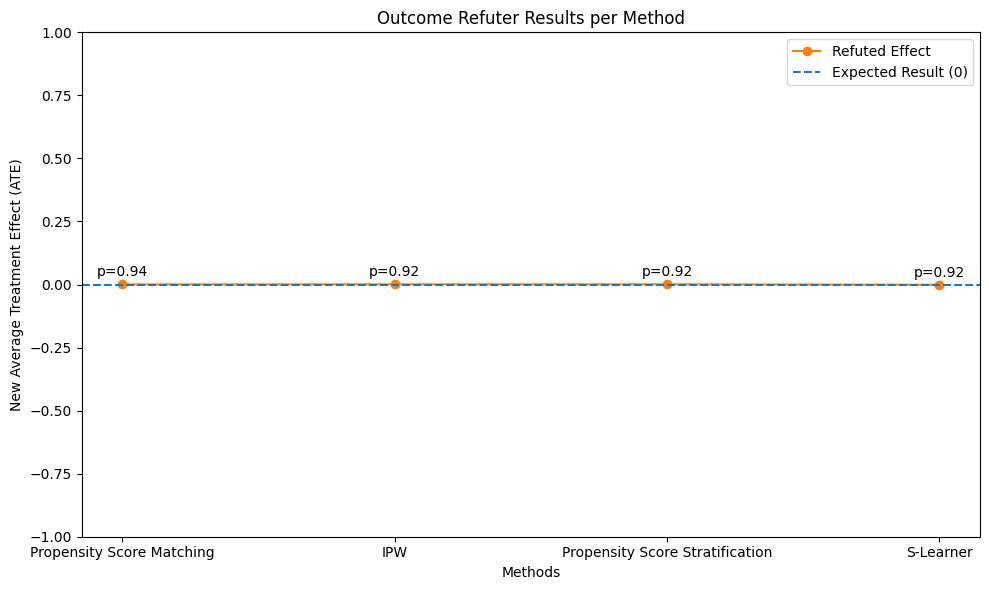

In [212]:
methods_names = [methods_new_names[m] for m in outcome_refuter.keys()]
methods = list(outcome_refuter.keys())
results = [outcome_refuter[m].new_effect for m in methods]
p_values = [outcome_refuter[m].refutation_result['p_value'] for m in methods]

plt.figure(figsize=(10, 6))
plt.plot(methods_names, results, marker='o', linestyle='-', color=ORANGE, label='Refuted Effect')
for i, (x, y, p) in enumerate(zip(methods_names, results, p_values)):
    plt.text(i, y + 0.02, f"p={p:.3g}", ha='center', va='bottom', fontsize=10)
plt.xlabel("Methods")
plt.ylabel("New Average Treatment Effect (ATE)")
plt.title("Outcome Refuter Results per Method")
plt.axhline(y=0, color=BLUE, linestyle='--', label='Expected Result (0)')
plt.ylim(-1, 1)
# plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

data subsampling

In [213]:
# Subset analysis
subset_percentages = [0.5, 0.7, 0.9]
subset_refuter = {}
for method in methods:
    if method not in ates:
        continue
    causal_estimate = ates[method]
    for subset_percentage in subset_percentages:
        res_subset_analysis = model.refute_estimate(estimand, causal_estimate, method_name="data_subset_refuter", subset_percentage=subset_percentage)
        subset_refuter[(method, subset_percentage)] = res_subset_analysis

    print(f"Subset analysis for {method}: {res_subset_analysis}")



Subset analysis for backdoor.propensity_score_matching: Refute: Use a subset of data
Estimated effect:6.601411446249033
New effect:6.479090057702183
p value:0.66

Subset analysis for backdoor.propensity_score_weighting: Refute: Use a subset of data
Estimated effect:7.120085531064994
New effect:7.137114750741386
p value:0.94

Subset analysis for backdoor.propensity_score_stratification: Refute: Use a subset of data
Estimated effect:6.9142121844960585
New effect:6.947547633127697
p value:0.8



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

Subset analysis for backdoor.linear_regression: Refute: Use a subset of data
Estimated effect:6.872629466263589
New effect:6.874876289737761
p value:1.0



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

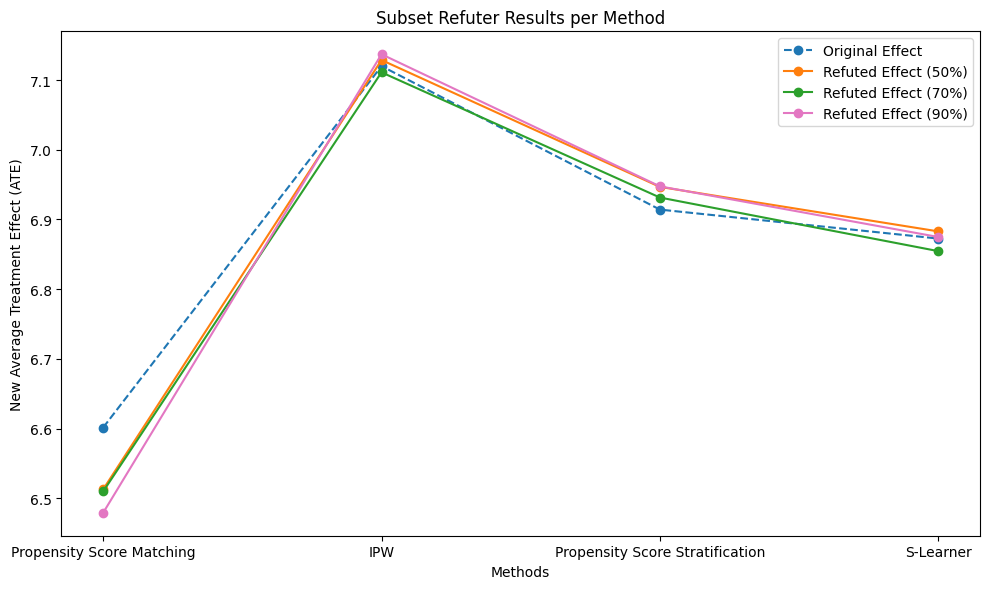

In [214]:
colors = [ORANGE, GREEN, PINK]
per_percentage_results = {}
for (method, percentage), results in subset_refuter.items():
    if percentage not in per_percentage_results:
        per_percentage_results[percentage] = {}
    per_percentage_results[percentage][method] = results
# generate a plot per percentage with all methods
plt.figure(figsize=(10, 6))
for _, results in per_percentage_results.items():
    methods = list(results.keys())
    break
methods_names = [methods_new_names[m] for m in methods]
orig_effect = [results[m].estimated_effect for m in methods]
plt.plot(methods_names, orig_effect, marker='o', linestyle='--', color=BLUE, label='Original Effect')
for i, (percentage, results) in enumerate(per_percentage_results.items()):
    # Map percentage to color
    color = colors[i % len(colors)]
    methods = list(results.keys())
    methods_names = [methods_new_names[m] for m in methods]
    new_effects = [results[m].new_effect for m in methods]
    p_values = [results[m].refutation_result['p_value'] for m in methods]

    plt.plot(methods_names, new_effects, marker='o', linestyle='-', color=color, label='Refuted Effect ({:.0f}%)'.format(percentage*100))
    # for i, (x, y, p) in enumerate(zip(methods_names, new_effects, p_values)):
    #     plt.text(i, y + 0.02, f"p={p:.3g}", ha='center', va='bottom', fontsize=10)
    plt.xlabel("Methods")
    plt.ylabel("New Average Treatment Effect (ATE)")
    plt.title(f"Subset Refuter Results per Method")
    # plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
plt.show()


In [215]:
# Random confounder
random_confounder_refuter = {}
for method in methods:
    if method not in ates:
        continue
    causal_estimate = ates[method]
    res_random = model.refute_estimate(estimand, causal_estimate, method_name="random_common_cause", placebo_type="permute")
    random_confounder_refuter[method] = res_random
    print(f"Random confounder test for {method}: {res_random}")



Random confounder test for backdoor.propensity_score_matching: Refute: Add a random common cause
Estimated effect:6.601411446249033
New effect:6.601411446249032
p value:1.0

Random confounder test for backdoor.propensity_score_weighting: Refute: Add a random common cause
Estimated effect:7.120085531064994
New effect:7.120085531064997
p value:1.0

Random confounder test for backdoor.propensity_score_stratification: Refute: Add a random common cause
Estimated effect:6.9142121844960585
New effect:6.914212184496057
p value:1.0



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

Random confounder test for backdoor.linear_regression: Refute: Add a random common cause
Estimated effect:6.872629466263589
New effect:6.8724633036432135
p value:1.0



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


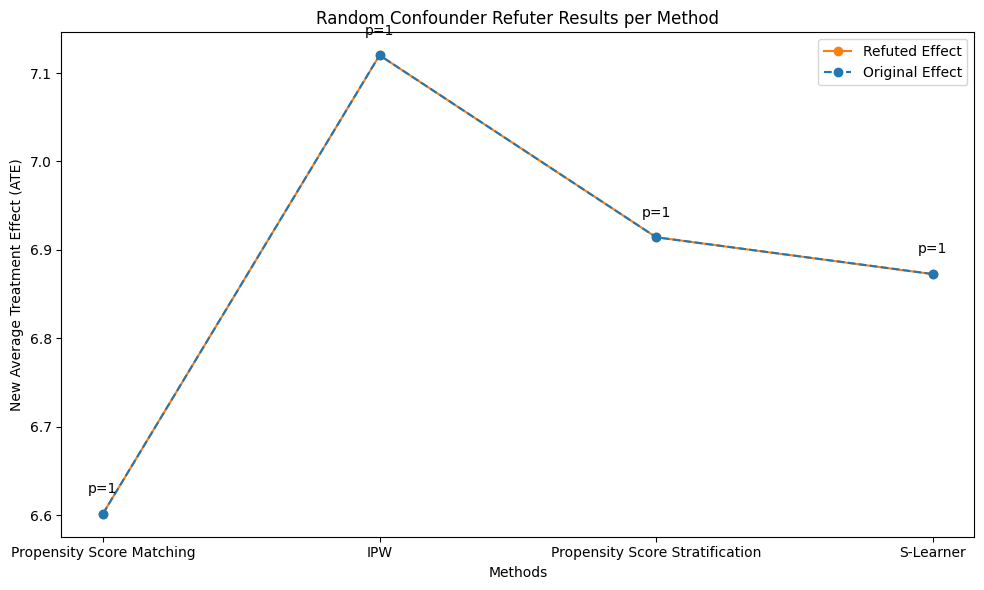

In [216]:
methods_names = [methods_new_names[m] for m in random_confounder_refuter.keys()]
methods = list(random_confounder_refuter.keys())
results = [random_confounder_refuter[m].new_effect for m in methods]
orig_effect = [random_confounder_refuter[m].estimated_effect for m in methods]
p_values = [random_confounder_refuter[m].refutation_result['p_value'] for m in methods]

plt.figure(figsize=(10, 6))
plt.plot(methods_names, results, marker='o', linestyle='-', color=ORANGE, label='Refuted Effect')
plt.plot(methods_names, orig_effect, marker='o', linestyle='--', color=BLUE, label='Original Effect')   
for i, (x, y, p) in enumerate(zip(methods_names, results, p_values)):
    plt.text(i, y + 0.02, f"p={p:.3g}", ha='center', va='bottom', fontsize=10)
plt.xlabel("Methods")
plt.ylabel("New Average Treatment Effect (ATE)")
plt.title("Random Confounder Refuter Results per Method")
# plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

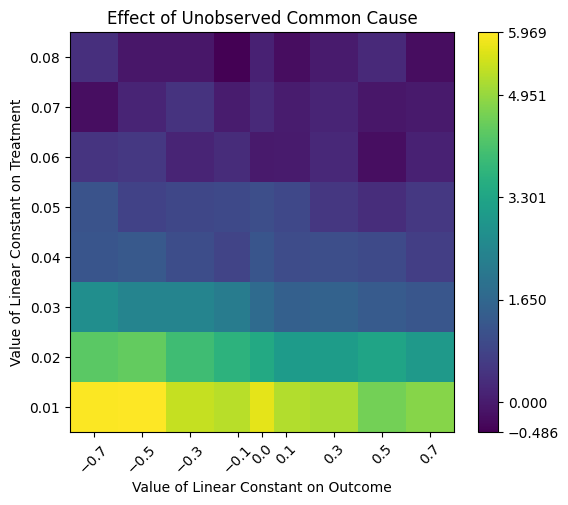

Linear Unobserved Confounder Simulation for method backdoor.propensity_score_matching: Refute: Add an Unobserved Common Cause
Estimated effect:6.601411446249033
New effect:(np.float64(-0.48563146463561513), np.float64(5.968598767411341))



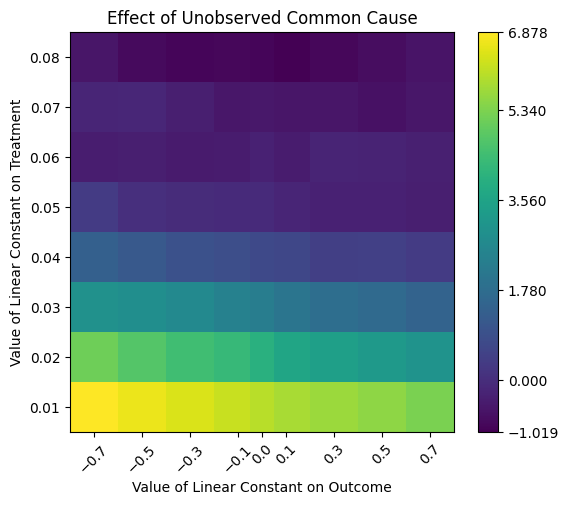

Linear Unobserved Confounder Simulation for method backdoor.propensity_score_weighting: Refute: Add an Unobserved Common Cause
Estimated effect:7.120085531064994
New effect:(np.float64(-1.0187167156210535), np.float64(6.877652571311501))



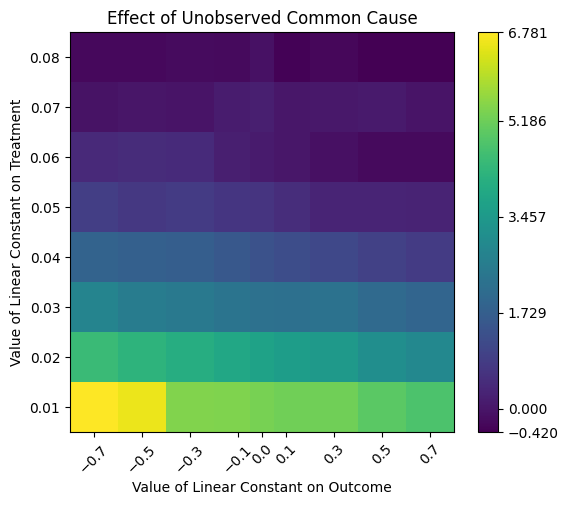

Linear Unobserved Confounder Simulation for method backdoor.propensity_score_stratification: Refute: Add an Unobserved Common Cause
Estimated effect:6.9142121844960585
New effect:(np.float64(-0.42023743010064435), np.float64(6.781313026948993))



/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/anaconda3/envs/causal/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

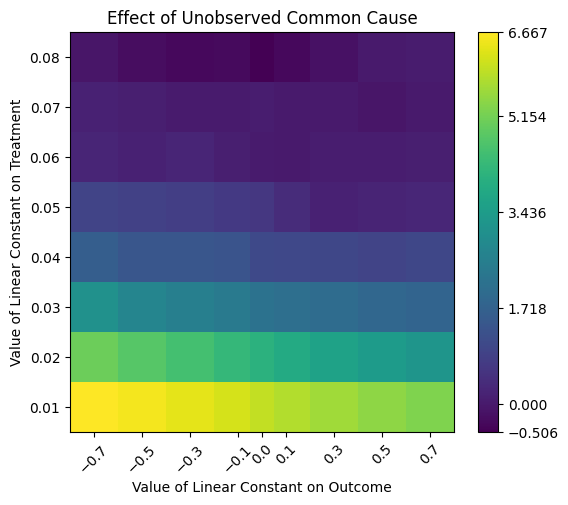

Linear Unobserved Confounder Simulation for method backdoor.linear_regression: Refute: Add an Unobserved Common Cause
Estimated effect:6.872629466263589
New effect:(np.float64(-0.5064162137908923), np.float64(6.666756311974609))



In [217]:
# Add unobserved confounder simulation
unobserved_confounder_refuter = {}
for method in methods:
    if method not in ates:
        continue
    causal_estimate = ates[method]
    res_unobserved = model.refute_estimate(estimand, causal_estimate,
            method_name="add_unobserved_common_cause",
            confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
            effect_strength_on_treatment=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08], effect_strength_on_outcome=[-0.7, -0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7])
    unobserved_confounder_refuter[method] = res_unobserved
    print(f"Linear Unobserved Confounder Simulation for method {method}: {res_unobserved}")


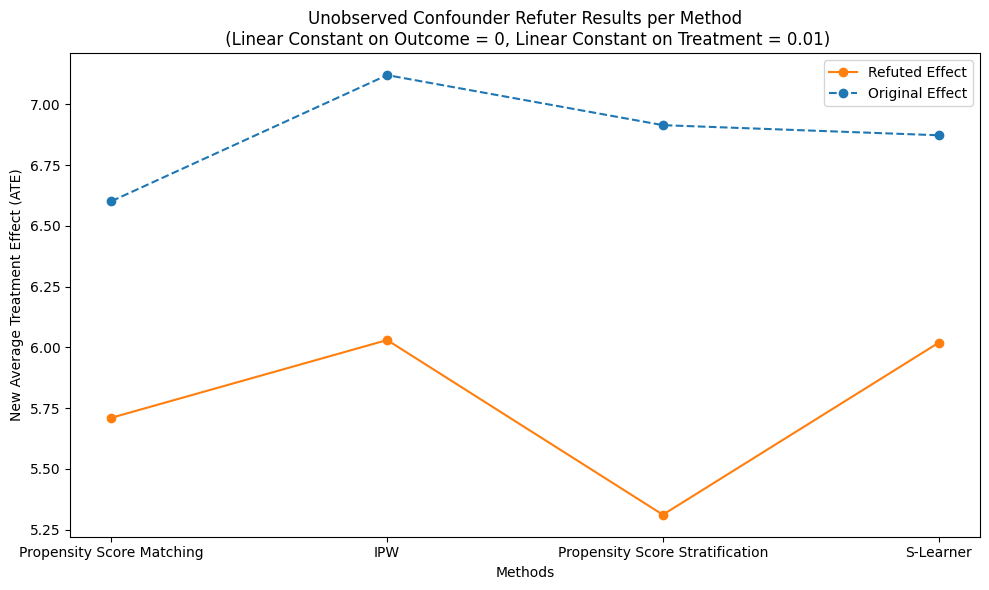

In [218]:
methods_names = [methods_new_names[m] for m in unobserved_confounder_refuter.keys()]
methods = list(unobserved_confounder_refuter.keys())
results = [unobserved_confounder_refuter[m].new_effect_array[0][4] for m in methods]
orig_effect = [unobserved_confounder_refuter[m].estimated_effect for m in methods]

plt.figure(figsize=(10, 6))
plt.plot(methods_names, results, marker='o', linestyle='-', color=ORANGE, label='Refuted Effect')
plt.plot(methods_names, orig_effect, marker='o', linestyle='--', color=BLUE, label='Original Effect')   
plt.xlabel("Methods")
plt.ylabel("New Average Treatment Effect (ATE)")
plt.title("Unobserved Confounder Refuter Results per Method\n (Linear Constant on Outcome = 0, Linear Constant on Treatment = 0.01)")
# plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()